In [760]:
import os
import spacy 
import pickle
import random
import nltk
import pandas as pd
import numpy as np
import nltk
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path
import spacy
from tqdm import tqdm
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import json
import xgboost

In [2]:
#!pip install jsonlines

Resume Dataset:

In [684]:
data_1 = pd.read_csv(r"UpdatedResumeDataSet.csv")
data_1

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [685]:
data_1['Resume'][0]

'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Ernst & Young LLP\r\ndescription - Fraud Investigatio

In [686]:
nlp = spacy.load("en_core_web_lg")
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

Skills Dataset to make the entities from Resume Dataset:

In [687]:
skill_pattern_path = r'jz_skill_patterns.jsonl'
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)

In [688]:
import re
clean = []
for i in range(data_1.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"'," ",
        str(data_1["Resume"].iloc[i])
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [689]:
def normalizing_data(dataFrame , data):
    clean = []
    for i in range(dataFrame.shape[0]):
        review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        str(data.iloc[i])
        )
        review = review.lower()
        review = review.split()
        lm = WordNetLemmatizer()
        review = [
            lm.lemmatize(word)
            for word in review
            if not word in set(stopwords.words("english"))
            ]
        review = " ".join(review)
        clean.append(review)

In [690]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset

In [691]:
def unique_skills(x):
    return list(set(x))

In [692]:
data_1["Resume_Cleaned"] = clean
data_1["skills"] = data_1["Resume_Cleaned"].str.lower().apply(get_skills)
data_1["skills"] = data_1["skills"].apply(unique_skills)
data_1.head()

,Category,Resume,Resume_Cleaned,skills
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda numpy ...,"[angular, mysql, computer vision, elasticsearc..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may 2013 may 2017 b e uit rgp...,"[machine learning, outlier, business, feature ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...,"[mysql, segmentation, analytics, github, segme..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,"[data processing, segmentation, analytics, seg..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...,"[data analysis, python, data structure, databa..."


In [12]:
clean_data_resume = data_1['Resume_Cleaned']
clean_data_resume.head()

0    skill programming language python panda numpy ...
1    education detail may 2013 may 2017 b e uit rgp...
2    area interest deep learning control system des...
3    skill r python sap hana tableau sap hana sql s...
4    education detail mca ymcaust faridabad haryana...
Name: Resume_Cleaned, dtype: object

In [13]:
clean_data_resume.shape

(962,)

In [14]:
skills = pd.read_csv(r'Dataset.csv')
Dataset_skills = skills['skills']
Dataset_skills

0                 business
1                 software
2       project management
3                marketing
4              engineering
               ...        
5184              security
5185              software
5186                  None
5187              security
5188              security
Name: skills, Length: 5189, dtype: object

In [15]:
#Dataset_skills.to_csv('worked_skills.csv')

In [16]:
Dataset_skills = pd.read_csv(r'worked_skills.csv')
Dataset_skills

,Unnamed: 0,skills
0,0,business
1,1,software
2,2,project management
3,3,marketing
4,4,engineering
...,...,...
5184,5184,security
5185,5185,software
5186,5186,None
5187,5187,security


In [17]:
annot = nlp(data_1['Resume'][2])
for entity in annot.ents:
    print(entity.text, entity.label_)

Deep Learning SKILL
Control System Design, Programming ORG
Python SKILL
Electric Machinery ORG
Web Development, Analytics Technical Activities ORG
Hindustan Aeronautics Limited ORG
Bangalore GPE
4 weeks DATE
Satish PERSON
Mirage 2000 ORG
Technical Skills Programming Matlab ORG
Python SKILL
Java GPE
Python WebFrameWork-Django ORG
Flask FAC
Languages NORP
MIPOWER ORG
Github GPE
Jupyter Notebook WORK_OF_ART
MySQL SKILL
Python SKILL
Software SKILL
Pycharm ORG
Java GPE
Eclipse SKILL
Operating Systems SKILL
Windows SKILL
Ubuntu PRODUCT
Debian-Kali NORP
Linux SKILL
January 2019 DATE
Electrical and Electronics Engineering  Manipal Institute of Technology ORG
January 2015 DATE
January 2013 DATE
DATA SCIENCE SKILL
DATA SCIENCE SKILL
Exprience - Less than 1 year months PERSON
Exprience - Less than 1 year months PERSON
Casino ORG
Macau GPE
segment SKILL
segmentation SKILL
marketing SKILL
business SKILL


In [ ]:
skill = []
for i in data_1['skills']:
    for j in i:
        skill.append(j)
print(len(skill))
skill = list(set(skill))
print(skill)

In [ ]:
len(skill)

In [ ]:
# reading skills from json file 
import json

f = open('jz_skill_patterns.jsonl', 'r')
skills_data = []
for line in f:
    f_line = json.loads(line)
    dummy = []
    for i in f_line['pattern']:
        dummy.append(list(i.values())[0].lower())
    dummy = ' '.join(dummy)
    skills_data.append(dummy)
    
print(len(skills_data))
print(skills_data)
skills_data = list(set(skills_data))
print(len(skills_data))
print(skills_data)

In [ ]:
for n in range(len(skills_data)):
    skills_data[n] = re.sub(r'\(|\)', '', skills_data[n])
print(skills_data)

In [ ]:
import csv
# list of name, degree, score 
skills_Data = skills_data
#Type = ['Skill'] 
     
# dictionary of lists  
dict = {'Text': skills_Data, 'Type': 'SKILL'}  
       
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('jobzilla_skills_it.csv')

In [ ]:
jobzilla_skills_it = pd.read_csv(r'jobzilla_skills_it.csv')
unnamed_cols = jobzilla_skills_it.columns.str.contains('Unnamed')
NEW_jobzilla_skills_it = jobzilla_skills_it.drop(jobzilla_skills_it[jobzilla_skills_it.columns[unnamed_cols]], axis=1)
NEW_jobzilla_skills_it.to_csv('jobzilla_skills_it.csv')
NEW_jobzilla_skills_it

In [ ]:
Dataset_skills = skills['skills']
Dataset_skills

In [ ]:
myData_Skills = pd.concat([Dataset_skills ,NEW_jobzilla_skills_it['Text']])
myData_Skills

In [ ]:
myData_Skills.shape

In [ ]:
myData_Skills.duplicated().sum()

In [ ]:
myData_Skills.drop_duplicates(inplace=True)
myData_Skills

In [ ]:
myData_Skills = myData_Skills.to_csv(r'myData_Skills.csv')


In [ ]:
myData_Skills = pd.read_csv(r'myData_Skills.csv')
myData_Skills

In [ ]:
TotalSkills = myData_Skills['0']

In [ ]:
#Type = 'SKILLS'
'''
with open("D:\Mechatronics Department\HITS internship\Skills.csv", "w", encoding="utf-8") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Text', 'Type'])
    for job in myData_Skills['0']: #skills['skills']
        csv_writer.writerow([job, Type])
'''        
SKILLS = myData_Skills
# dictionary of lists  
dict = {'Text': skills_Data, 'Type': 'SKILL'}  
df = pd.DataFrame(dict) 
# saving the dataframe 
df.to_csv('Skills.csv') 

In [ ]:
myData_Skills = pd.read_csv(r'Skills.csv')
myData_Skills = myData_Skills['Text']
myData_Skills

In [ ]:
for n, i in enumerate(myData_Skills):
    dummy = re.sub('\'$|\'(?= )|\"|\/ |\*', '', i) # remove any ' " * / 
    dummy = re.sub(r'\/', ' ', dummy) # remove and two words sperated with / char with space like A/B to AB
    dummy = re.sub(r'  |^ ', '', dummy) # remove more that one white space
    if '+' in i:
        dummy = dummy.replace('+', '\+') # change ++ to \+\+
    myData_Skills[n] = dummy 
myData_Skills.head()

In [ ]:
with open("skills list.txt", 'r') as file:
    SKILLS = file.readlines()
    print(SKILLS)

In [ ]:
type(SKILLS)

In [ ]:
with open("skills list.txt", 'r') as file:
    SKILLS = file.readlines()  
# dictionary of lists
dict = {'Text': SKILLS, 'Type': 'SKILL'}        
df = pd.DataFrame(dict) 
# saving the dataframe
df.to_csv('new skills.csv')

In [461]:
Skills = pd.read_csv(r'new skills.csv')
Skills

,Unnamed: 0,Text,Type
0,0,3d math\n,SKILL
1,1,3d modeling software\n,SKILL
2,2,3d modeling\n,SKILL
3,3,3d packaging\n,SKILL
4,4,3d particles and dynamics\n,SKILL
...,...,...,...
639,639,Audio Editing software\n,NaN
640,640,FPGA,NaN
641,641,Field Programmable Gate Arrays,NaN
642,642,Software Architecture,NaN


In [462]:
Skills['Text'][100]

'Computer Vision\n'

In [463]:
NewSkills = pd.read_csv(r'new skills.csv')
NewSkills = Skills['Text'].str.strip()
NewSkills = NewSkills.str.lower()
NewSkills

0                             3d math
1                3d modeling software
2                         3d modeling
3                        3d packaging
4           3d particles and dynamics
                    ...              
639            audio editing software
640                              fpga
641    field programmable gate arrays
642             software architecture
643                               etl
Name: Text, Length: 644, dtype: object

In [464]:
NewSkills[10:15]

10                 algorithms
11    autonomous driving cars
12                   auditing
13                    autocad
14                 automotive
Name: Text, dtype: object

In [465]:
NewSkills.duplicated().sum()
NewSkills.drop_duplicates(inplace=True)
NewSkills

0                             3d math
1                3d modeling software
2                         3d modeling
3                        3d packaging
4           3d particles and dynamics
                    ...              
639            audio editing software
640                              fpga
641    field programmable gate arrays
642             software architecture
643                               etl
Name: Text, Length: 614, dtype: object

In [466]:
NewSkills.duplicated().sum()

0

In [467]:
for n, i in enumerate(NewSkills):
    dummy = re.sub('\'$|\'(?= )|\"\/ |\*', '', i) # remove any ' " * / 
    dummy = re.sub(r'\/', ' ', dummy) # remove and two words sperated with / char with space like A/B to AB
    dummy = re.sub(r'  |^ ', '', dummy) # remove more that one white space
    if '+' in i:
        dummy = dummy.replace('+', '\+') # change ++ to \+\+
    NewSkills[n] = dummy
NewSkills.head()

0                      3d math
1         3d modeling software
2                  3d modeling
3                 3d packaging
4    3d particles and dynamics
Name: Text, dtype: object

In [ ]:
NewSkills[10:100].to_csv('samples of skills.csv')

In [468]:
sentence = 'skill programming language python panda numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na bayes knn random forest decision tree boosting technique cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural net database visualization mysql sqlserver cassandra hbase elasticsearch d3 j dc j plotly kibana matplotlib ggplot tableau others regular expression html cs angular 6 logstash kafka python flask git docker computer vision open cv understanding deep learning education detail data science assurance associate data science assurance associate ernst young llp skill detail javascript exprience 24 month jquery exprience 24 month python exprience 24 monthscompany detail company ernst young llp description fraud investigation dispute service assurance technology assisted review tar technology assisted review assist accelerating review process run analytics generate report core member team helped developing automated review platform tool scratch assisting e discovery domain tool implement predictive coding topic modelling automating review resulting reduced labor cost time spent lawyer review understand end end flow solution research development classification model predictive analysis mining information present text data worked analyzing output precision monitoring entire tool tar assist predictive coding topic modelling evidence following ey standard developed classifier model order identify red flag fraud related issue tool technology python scikit learn tfidf word2vec doc2vec cosine similarity na bayes lda nmf topic modelling vader text blob sentiment analysis matplot lib tableau dashboard reporting multiple data science analytic project usa client text analytics motor vehicle customer review data received customer feedback survey data past one year performed sentiment positive negative neutral time series analysis customer comment across 4 category created heat map term survey category based frequency word extracted positive negative word across survey category plotted word cloud created customized tableau dashboard effective reporting visualization chatbot developed user friendly chatbot one product handle simple question hour operation reservation option chat bot serf entire product related question giving overview tool via qa platform also give recommendation response user question build chain relevant answer intelligence build pipeline question per user requirement asks relevant recommended question tool technology python natural language processing nltk spacy topic modelling sentiment analysis word embedding scikit learn javascript jquery sqlserver information governance organization make informed decision information store integrated information governance portfolio synthesizes intelligence across unstructured data source facilitates action ensure organization best positioned counter information risk scan data multiple source format parse different file format extract meta data information push result indexing elastic search created customized interactive dashboard using kibana preforming rot analysis data give information data help identify content either redundant outdated trivial preforming full text search analysis elastic search predefined method tag pii personally identifiable information social security number address name etc frequently targeted cyber attack tool technology python flask elastic search kibana fraud analytic platform fraud analytics investigative platform review red flag case fap fraud analytics investigative platform inbuilt case manager suite analytics various erp system used client interrogate accounting system identifying anomaly indicator fraud'
annot = re.finditer(rf'\bartificial intelligence\b', sentence)
print(annot)

In [469]:
type(NewSkills)

pandas.core.series.Series

In [470]:
(NewSkills.eq('python')).any()

True

In [471]:
# NewSkills[NewSkills=='']
# NewSkills[129]
# NewSkills.drop(labels=129, axis=0, inplace=True)
NewSkills.head()

0                      3d math
1         3d modeling software
2                  3d modeling
3                 3d packaging
4    3d particles and dynamics
Name: Text, dtype: object

In [472]:
NewSkills[100]

'cvs (concurrent versions system)'

In [473]:
%%time
import re
from tqdm import tqdm
resume_sample = ['algorithms autonomous driving cars auditing autocad automotive art arduino ai artificial intelligence audio video processing analytical skill dobe photoshop']
label = 'SKILL'
sample_data = []
for sentence in tqdm(resume_sample):
    data_entities = {'entities': []}
    for skill in NewSkills:
#       print(skill)
        for i in re.finditer(rf'\b{skill}\b', sentence):
            data_entities['entities'].append((i.start(), i.end(), label))
            #print(i.start(), i.end(), skill)

    sample_data.append([sentence, data_entities])
sample_data

100%|██████████| 1/1 [00:00<00:00, 38.56it/s]

Wall time: 30.9 ms


[['algorithms autonomous driving cars auditing autocad automotive art arduino ai artificial intelligence audio video processing analytical skill dobe photoshop',
  {'entities': [(0, 10, 'SKILL'),
    (11, 34, 'SKILL'),
    (35, 43, 'SKILL'),
    (44, 51, 'SKILL'),
    (52, 62, 'SKILL'),
    (63, 66, 'SKILL'),
    (67, 74, 'SKILL'),
    (75, 77, 'SKILL'),
    (78, 101, 'SKILL')]}]]

In [474]:
len(sample_data)

1

In [475]:
sample_data[0]

['algorithms autonomous driving cars auditing autocad automotive art arduino ai artificial intelligence audio video processing analytical skill dobe photoshop',
 {'entities': [(0, 10, 'SKILL'),
   (11, 34, 'SKILL'),
   (35, 43, 'SKILL'),
   (44, 51, 'SKILL'),
   (52, 62, 'SKILL'),
   (63, 66, 'SKILL'),
   (67, 74, 'SKILL'),
   (75, 77, 'SKILL'),
   (78, 101, 'SKILL')]}]

In [476]:
sentence = 'skill programming language python panda numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na bayes knn random forest decision tree boosting technique cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural net database visualization mysql sqlserver cassandra hbase elasticsearch d3 j dc j plotly kibana matplotlib ggplot tableau others regular expression html cs angular 6 logstash kafka python flask git docker computer vision open cv understanding deep learning education detail data science assurance associate data science assurance associate ernst young llp skill detail javascript exprience 24 month jquery exprience 24 month python exprience 24 monthscompany detail company ernst young llp description fraud investigation dispute service assurance technology assisted review tar technology assisted review assist accelerating review process run analytics generate report core member team helped developing automated review platform tool scratch assisting e discovery domain tool implement predictive coding topic modelling automating review resulting reduced labor cost time spent lawyer review understand end end flow solution research development classification model predictive analysis mining information present text data worked analyzing output precision monitoring entire tool tar assist predictive coding topic modelling evidence following ey standard developed classifier model order identify red flag fraud related issue tool technology python scikit learn tfidf word2vec doc2vec cosine similarity na bayes lda nmf topic modelling vader text blob sentiment analysis matplot lib tableau dashboard reporting multiple data science analytic project usa client text analytics motor vehicle customer review data received customer feedback survey data past one year performed sentiment positive negative neutral time series analysis customer comment across 4 category created heat map term survey category based frequency word extracted positive negative word across survey category plotted word cloud created customized tableau dashboard effective reporting visualization chatbot developed user friendly chatbot one product handle simple question hour operation reservation option chat bot serf entire product related question giving overview tool via qa platform also give recommendation response user question build chain relevant answer intelligence build pipeline question per user requirement asks relevant recommended question tool technology python natural language processing nltk spacy topic modelling sentiment analysis word embedding scikit learn javascript jquery sqlserver information governance organization make informed decision information store integrated information governance portfolio synthesizes intelligence across unstructured data source facilitates action ensure organization best positioned counter information risk scan data multiple source format parse different file format extract meta data information push result indexing elastic search created customized interactive dashboard using kibana preforming rot analysis data give information data help identify content either redundant outdated trivial preforming full text search analysis elastic search predefined method tag pii personally identifiable information social security number address name etc frequently targeted cyber attack tool technology python flask elastic search kibana fraud analytic platform fraud analytics investigative platform review red flag case fap fraud analytics investigative platform inbuilt case manager suite analytics various erp system used client interrogate accounting system identifying anomaly indicator fraud running advanced analytics tool technology html javascript sqlserver jquery cs bootstrap node j d3 j dc j'
sample_data=[]
data_entities = {'entities': []}
for skill in NewSkills:
    for i in re.finditer(rf'\b{skill}\b', sentence):
        data_entities['entities'].append([i.start(), i.end(), label])
#         print(i.start(), i.end(), skill, sentence[i.start():i.end()])
sample_data.append([sentence, data_entities])
sample_data

[['skill programming language python panda numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na bayes knn random forest decision tree boosting technique cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural net database visualization mysql sqlserver cassandra hbase elasticsearch d3 j dc j plotly kibana matplotlib ggplot tableau others regular expression html cs angular 6 logstash kafka python flask git docker computer vision open cv understanding deep learning education detail data science assurance associate data science assurance associate ernst young llp skill detail javascript exprience 24 month jquery exprience 24 month python exprience 24 monthscompany detail company ernst young llp description fraud investigation dispute service assurance technology assisted review tar technology assisted review assist accelerating review process run analytics generat

In [ ]:
sentence[642:654]

In [610]:
'''import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
nlp = spacy.blank('en') # load a new spacy model
db = DocBin() # create a DocBin object
from spacy.util import filter_spans

for text, annot in tqdm(output_data): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot['entities']: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode='contract')
        if span is None:
            print('Skipping entity')
            print(start, end, label, text[start:end])
        else:
            ents.append(span)
            
    filtered_ents = filter_spans(ents)    
    try:
        doc.ents = ents # label the text with the ents
        db.add(doc)
    except:
        print(text, annot)
db.to_disk('./TRAINSET.spacy') # save the docbin object'''

"import spacy\nfrom spacy.tokens import DocBin\nfrom tqdm import tqdm\nnlp = spacy.blank('en') # load a new spacy model\ndb = DocBin() # create a DocBin object\nfrom spacy.util import filter_spans\n\nfor text, annot in tqdm(output_data): # data in previous format\n    doc = nlp.make_doc(text) # create doc object from text\n    ents = []\n    for start, end, label in annot['entities']: # add character indexes\n        span = doc.char_span(start, end, label=label, alignment_mode='contract')\n        if span is None:\n            print('Skipping entity')\n            print(start, end, label, text[start:end])\n        else:\n            ents.append(span)\n            \n    filtered_ents = filter_spans(ents)    \n    try:\n        doc.ents = ents # label the text with the ents\n        db.add(doc)\n    except:\n        print(text, annot)\ndb.to_disk('./TRAINSET.spacy') # save the docbin object"

In [477]:
def annotate_the_data(data, skills, label='SKILLS'):
    output_data = []
    for cv in tqdm(data):
        data_entities = {'entities': []}
        for skill in skills:
            for i in re.finditer(rf'\b{skill}\b', cv):
                data_entities['entities'].append((i.start(), i.end(), label))
        output_data.append([cv, data_entities])
    return output_data

In [531]:
%%time
output_data = annotate_the_data(data_1["Resume_Cleaned"], NewSkills, label='SKILL')

100%|██████████| 962/962 [00:48<00:00, 19.84it/s]


In [539]:
print(output_data[3])

['skill r python sap hana tableau sap hana sql sap hana pal m sql sap lumira c linear programming data modelling advance analytics scm analytics retail analytics social medium analytics nlp education detail january 2017 january 2018 pgdm business analytics great lake institute management illinois institute technology january 2013 bachelor engineering electronics communication bengaluru karnataka new horizon college engineering bangalore visvesvaraya technological university data science consultant consultant deloitte usi skill detail linear programming exprience 6 month retail exprience 6 month retail marketing exprience 6 month scm exprience 6 month sql exprience le 1 year month deep learning exprience le 1 year month machine learning exprience le 1 year month python exprience le 1 year month r exprience le 1 year monthscompany detail company deloitte usi description project involved analysing historic deal coming insight optimize future deal role given raw data carried end end analys

In [596]:
def train_dev_split(all_annotated_data, percent=0.15):
  # shuffle the data
    data = all_annotated_data.copy()
    random.shuffle(data)

  # split the data to train, dev sets 
    split_len = int(len(data) * (1-percent))
    train_data = data[:split_len]
    dev_data   = data[split_len:]
    return train_data, dev_data

In [606]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
nlp = spacy.blank('en') # load a new spacy model
db = DocBin() # create a DocBin object
def make_spacy_file(annotated_data, file_path):
    nlp = spacy.blank('en') # load a new spacy model
    db = DocBin() # create a DocBin object
    for text, annot in tqdm(annotated_data): # data in previous format
        doc = nlp.make_doc(text) # create doc object from text
        ents = []
        for start, end, label in annot['entities']: # add character indexes
            span = doc.char_span(start, end, label=label, alignment_mode='expand')
            if span is None:
                print('Skipping entity')
                # print(span, start, end, label, text[start:end])
            else:
                ents.append(span)
        try:
            filtered = filter_spans(ents)
            doc.ents = filtered # label the text with the ents
            db.add(doc)
        except:
            print(text, annot)
    db.to_disk(f'{file_path}.spacy') # save the docbin object

In [607]:
train_data, test_data = train_dev_split(output_data, percent=0.2)
print(len(train_data) , len(test_data))

769 193


In [608]:
train_path = 'train'
dev_path   = 'dev'

In [487]:

dev_path  = 

In [609]:
make_spacy_file(train_data, train_path)
make_spacy_file(test_data, dev_path)

100%|██████████| 193/193 [00:00<00:00, 517.04it/s]


In [611]:
train_data[0]

['skill m office photoshop sql server education detail june 2015 bachelor yashwantrao chavan maharashtra university sale manager sale manager skill detail m office exprience 6 month m sql server exprience 6 month photoshop exprience 6 month sql exprience 6 month sql server exprience 6 monthscompany detail company nature work description generating lead call suggesting residential property per client budget specification building relationship channel partner meeting client project presentation follow site visit deal closure worked icici merchant service hg payroll sale manager 16th jan 2017 till 30th aug 2018 nature work sale po edc machine sme loan loan electronic payment acquiring new merchant retaing existing merchant cold calling casa team icici bank generating lead field visit providing demo retailer shopkeeper sme corporate merchant closing signup worked mahal pvt ltd sr sale executive 04th mar 2016 03 jan 2017 nature work calling lead gegenerat interacting client call suggesting 

In [612]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [624]:
%%time
!python -m spacy train config.cfg --output ./model_output --paths.train ./train.spacy --paths.dev ./dev.spacy

[i] Saving to output directory: model_output
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
[!] Saving logs is disabled because training_log.jsonl already
exists.
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    254.67    0.10    0.30    0.06    0.00
  0     200         22.16   5620.41   90.89   95.34   86.85    0.91
  0     400         35.63   1152.28   95.87   96.52   95.23    0.96
  0     600         56.83    750.74   96.08   98.08   94.16    0.96
  1     800        117.67    638.46   96.35   95.14   97.59    0.96
  1    1000        142.69    397.52   96.69   98.75   94.72    0.97
  1    1200        175.29    367.93   98.03   99.46   96.64    0.98
  1    1400 

[2023-03-08 13:23:21,042] [INFO] Set up nlp object from config
[2023-03-08 13:23:21,052] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-03-08 13:23:21,052] [INFO] Created vocabulary
[2023-03-08 13:23:22,162] [INFO] Added vectors: en_core_web_lg
[2023-03-08 13:23:23,082] [INFO] Finished initializing nlp object
[2023-03-08 13:23:27,782] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


In [625]:
print(len(train_data) , len(test_data))

769 193


In [626]:
f = open('training_log.jsonl', 'r')

for line in f:
    f_line = json.loads(line)
f_line

{'epoch': 11,
 'step': 5800,
 'losses': {'tok2vec': 112.573921654, 'ner': 20.8146250369},
 'scores': {'ents_f': 99.7585513078,
  'ents_p': 99.6382636656,
  'ents_r': 99.8791297341},
 'score': 0.9975855131}

In [693]:
f = open('training_log.jsonl', 'r')

f_line = json.loads(f.readline())
logs_keys = list(f_line.keys())
print(logs_keys)
logs_out = {}
for i in logs_keys:
    logs_out[i]=[]
print(logs_out)    
for line in f:
    f_line = json.loads(line)    
    for i in logs_keys:
        logs_out[i].append(f_line[i])
print('\n' , logs_out)

['epoch', 'step', 'losses', 'scores', 'score']
{'epoch': [], 'step': [], 'losses': [], 'scores': [], 'score': []}

 {'epoch': [0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, 8, 9, 10, 10, 11], 'step': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800], 'losses': [{'tok2vec': 25.7890432709, 'ner': 4685.1134768997}, {'tok2vec': 44.803616385, 'ner': 958.7312354074}, {'tok2vec': 82.3440565103, 'ner': 656.506755439}, {'tok2vec': 101.4838313209, 'ner': 461.691731742}, {'tok2vec': 83.7431972975, 'ner': 244.8225935059}, {'tok2vec': 164.8761005926, 'ner': 350.084502251}, {'tok2vec': 141.7892385766, 'ner': 228.3929902627}, {'tok2vec': 193.8643192558, 'ner': 228.8416952035}, {'tok2vec': 167.9341755273, 'ner': 236.3189659022}, {'tok2vec': 155.3077225835, 'ner': 110.3270071852}, {'tok2vec': 189.3559566161, 'ner': 88.2318026738}, {'tok2vec': 153.3025467313,

In [694]:
#loss = list(logs_out['losses'])
losses = []
for loss in logs_out['losses']:
    losses.append(loss['ner'])
print(losses)
len(losses)

[4685.1134768997, 958.7312354074, 656.506755439, 461.691731742, 244.8225935059, 350.084502251, 228.3929902627, 228.8416952035, 236.3189659022, 110.3270071852, 88.2318026738, 118.7458722678, 124.1223995202, 116.6342837506, 75.4551613292, 85.9490429209, 90.4929886972, 125.3651808744, 65.4101313406, 79.5179079741, 81.6239038158, 68.2532582729, 47.27351761, 82.5878631854, 66.8200718475, 32.2545164698, 22.9511266868, 51.5213528098, 20.8146250369]


29

In [695]:
score = list(logs_out['score'])
scores = []
for score in logs_out['score']:
    scores.append(score*100)
print(scores)
len(scores)

[91.12885818999999, 94.1765059, 96.01930036, 97.40339399, 97.01187064999999, 96.11191113000001, 98.56573705, 99.09292481, 99.23263328, 99.53750251, 99.61732125, 99.43502825, 99.53619680999999, 99.65815403, 99.57584326, 99.61685824, 99.07630522000001, 99.73816717, 99.79822437, 99.69776345, 100.0, 99.89925448, 99.71876256, 99.9798509, 99.95972614, 100.0, 99.87922705, 99.97985901, 99.75855131]


29

In [696]:
recall = []
for loss in logs_out['scores']:
    recall.append(loss['ents_r'])
print(recall)
len(recall)

[85.0523771152, 94.8025785657, 96.212731668, 95.9709911362, 95.4875100725, 94.1176470588, 99.6776792909, 99.0330378727, 98.992747784, 99.7179693795, 99.6373892023, 99.2747784045, 99.4359387591, 99.8388396454, 99.3150684932, 99.5165189363, 99.3956486704, 99.7582594682, 99.6373892023, 99.6776792909, 100.0, 99.8791297341, 100.0, 99.9597099114, 100.0, 100.0, 99.9597099114, 100.0, 99.8791297341]


29

In [697]:
F_Score = []
for loss in logs_out['scores']:
    F_Score.append(loss['ents_f'])
print(F_Score)
len(F_Score)

[91.1288581912, 94.1765059035, 96.0193003619, 97.403393989, 97.0118706508, 96.1119111294, 98.5657370518, 99.0929248135, 99.2326332795, 99.5375025136, 99.6173212487, 99.4350282486, 99.5361968139, 99.6581540318, 99.575843264, 99.6168582375, 99.0763052209, 99.7381671702, 99.7982243745, 99.6977634495, 100.0, 99.8992544832, 99.7187625552, 99.9798508966, 99.9597261377, 100.0, 99.8792270531, 99.9798590131, 99.7585513078]


29

In [698]:
precision = []
for loss in logs_out['scores']:
    precision.append(loss['ents_p'])
print(precision)
len(precision)

[98.140399814, 93.5586481113, 95.8266452648, 98.8792029888, 98.5856905158, 98.1925178646, 97.4783293932, 99.1528842275, 99.4736842105, 99.3576876756, 99.5972613774, 99.5957962813, 99.6366572467, 99.4781212365, 99.8379910895, 99.7174000807, 98.7590072058, 99.7180829642, 99.9595796281, 99.7178557033, 100.0, 99.9193873438, 99.4391025641, 100.0, 99.9194847021, 100.0, 99.7988736927, 99.9597261377, 99.6382636656]


29

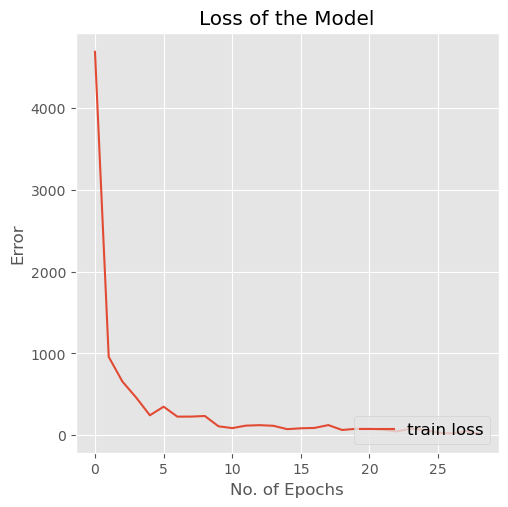

In [699]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(losses)
#plt.plot(recalls)
plt.title('Loss of the Model')
plt.ylabel('Error', fontsize=12)
plt.xlabel('No. of Epochs', fontsize=12)
plt.legend(['train loss'], loc='lower right', prop={'size': 12})

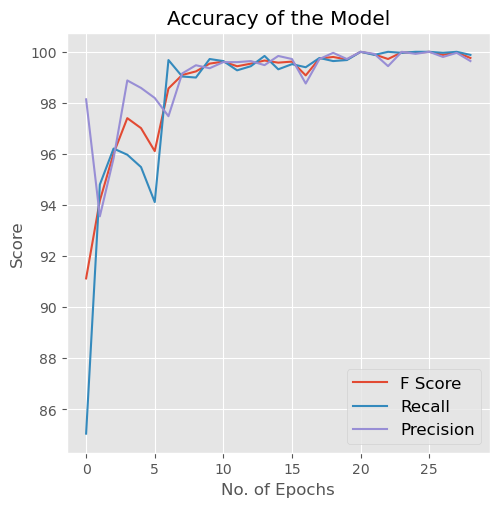

In [700]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(F_Score)           
plt.plot(recall)
plt.plot(precision)           
plt.title('Accuracy of the Model')
plt.ylabel('Score', fontsize=12)
plt.xlabel('No. of Epochs', fontsize=12)
plt.legend(['F Score', 'Recall','Precision'], loc='lower right', prop={'size': 12})

In [701]:
model = spacy.load('model_output\model-best') #load the model

In [636]:
resume_sample = 'Systems Administrator  Engineer Systems Administrator  Engineer  WellsFargo Toms Rivers NJ Linux Unix Systems Administrator Engineer  Talented and passionate system engineer with 6 years plus of experience as a systems engineer Strong analytical and troubleshooting abilities with a deep understanding of Linux Red Hat networking virtualization management cloud computing AWS DevOps automation with puppet and Ansible and more Excellent interpersonal skills with experience working with teams to productively troubleshoot and resolve challenging technical issues CAREER PROFILE  Expertise in RHEL 567  Racking and stacking of Servers for provisioning  Experience with setting different RAID levels  Experience with building hypervisors by installing VMWare ESXi on bare metal machines  Experience in provisioning servers using pxeboot and kickstart to automate installation of OS  Expertise in configuring managing and troubleshooting of different servers such as NFS NIS with autofs Yum Repository Server DNS DHCP FTP Samba LDAP LAMP  Experience in disk partitioning using FDISK  Creation and Management of Physical Volumes Volume Groups Logical Volumes using LVM  Creating various file systems on logical volumes as well as resizing which includes extending and shrinking using LVM  Experience with configuring monitoring and troubleshooting of different file systems such as EXT 2 3 4 and XFS as well as upgrading file systems as needed using tune FS  Experience in Installation Configuration Backup Recovery Maintenance Support of Red Hat Linux and other flavors  Applying patches for security fixes using Ansible blade logic Redhat Satellite Server  Experience with Yum and RPM to install various Packages on Redhat Linux Environments as well as actively applying Security Patches to keep Production  Development  Configuration of NIC Bonding for redundancy and performance such as Round Robin and Active backup to increase network bandwidth and redundancy for NIC Cards  Experience with creating and managing virtual machines clusters and migration of VMs from host to host using vmotion on Vcenter  Wrote Scripts for Day to Day tasks such as groupuser administration start up and shutdown scripts Crontabs  Experience with configuring an ansible server for automation writing adhoc commands and playbooks for user management and creating servers  Deployment and system build configuration using ansible and puppet as well as monitoring and setting sensors using Nagios  Experience in using various network protocols like SSH SCP SFTP HTTP TCPIP UDP FTP SMTP  Experience with Kernel tuning as needed especially for virtual memory swap space  Excellent verbal and written communication skills with experience in direct internal and external client relationship management  Ability to learn and adapt to new and different technologies to a working depth quickly and efficiently  247 customer support and service delivery experience Authorized to work in United States for any employer Work Experience Systems Administrator  Engineer WellsFargo Toms Rivers NJ January 2016 to Present  Knowledge of AWS administration which includes deploying and configuring EC2 instances and S3 and managing IAM roles  Installing maintaining administration and troubleshooting of Linux and Unix Systems  Working directly with Vendor to decommission thousands of servers and networking equipment following Company rules and regulations  Working with vendors to replace server parts and ordering new hardware  Keeping track of system inventory commissioning and decommissioning HP assets and deleting data from servers  Ensuring data destructions before decommissioning assets  Securing SSH with key based authentication with RSA encryption  Setting up autofs mounting for home directories with NIS and LDAP configurations  Providing direct user support for level 2 and level 3 issues via email and ticket system  Providing timely and responsive assistance to company employees by troubleshooting problems as reported the helpdesk ticketing system  Experienced using network traffic monitoring tools such as Wireshark and tcpdump  Performing automated installations of operating systems over the network for various distributions such as Redhat CentOS Ubuntu Fedora as well as Server Provisioning tool such as HPSA  Working with different storage containers creating RAID levels 0 1 5 6 10 to achieve redundancy and performance  Compile opensource software from source code Generate necessary RPM packages for proper documentation and replication across server environment  Performing daily system monitoring verifying the integrity and availability of all hardware server resources systems and key processes reviewing system and application logs and verifying completion of scheduled jobs such as backups  Performing filesystem checks and repairing when needed  Repairing and rebuilding existing servers as per project requirement  Responsible for backing up all systems using NetBackup 75 and restoring files in the event of data loss  Setup cron jobs schedules for various backup and monitoring tasks supported with enterprise backups using Netbackup  Monitoring Netbackup queue for failed backup jobs and taking actions to fix them  Responsible for User management which includes creating modifying renewing user accounts and groups on Linux NIS Ldap as well as Active directory  Setting up NIS domains master server slave and clients and resolving authentication issues  Mounting user home directories through automount and setting up quota system  Installation of ESXi Hypervisor Servers VSphere clients and Vcenter Servers  Installing ESXI servers 55 60  Building Vcenter and adding ESXI servers to it  Creating moving and cloning VMs using Vcenter Vsphere as well as Vmotion  Automating all aspects of VMware VSphere infrastructure with VMware VRealize Orchestrator  Testing and Deploying security patches to number of systems on Dev and Production environment  Perform software package installation upgrades and updates using yum and rpm commands  Maintaining inventory of all incoming and outgoing equipment  Monitoring the UPS systems for generated alerts  Monitoring the infrastructure health using Nagios and proprietary data center monitoring tools  Working with different file systems such as ext3 ext4 xfs and NFS partitioning using fdisk parted to create different partitions creating and fixing file systems  Maintaining the YUM repository server for patch management as well as securing Linux systems using local repository and installing upgrading applications on Linux Systems  Helping with user management such as creating modifying and disabling accounts I set up home directories on servers added users to appropriate groups and assigned sudo access when requested  Created and managed Logical Volume using LVM to create volumes on the volume groups and file systems  Performing physical to virtual machine conversions  Performing critical system administration tasks from Single user mode  Creating mount points for database administrators Supported MySQL database  Configure NTP client on servers to synchronize time zone with the NTP server  Responding to the alerts generated by Nagios such as network connectivity issues critical system services application availability high CPU spikes and systems resources being maxed out  Researches evaluates and recommends software and hardware products  Actively participated in data center operations building scaling servers from ordering hardware to racking them up Ability to pick up heavy equipment  Solid understanding and working knowledge of storage technologies such as SAN NAS and ISCSI  Troubleshooting Linux network security related issues capturing packets using tools such as IPtables firewall TCP wrappers NMAP  Troubleshooting and maintaining of TCPIP Apache HTTPS SMTP and DNS applications  Installing and managing new servers which includes racking stacking cabling running fiber and LAN patch  Configured multiple websites on one Apache http server using VirtualHost containers  Creatingupdating iptables rules on Linux systems using hostbased firewall  Solving issues related to user logon NFS and server connectivity  Configuring NFS server and mount exported NFS resources at the client side  Experience with bash scripting  Creating and modifying bash scripts to automate my daily tasks  Setup NFS and Samba File sharing setup on Linux for Windows servers and machines  Conducting system performance tuning and capacity planning  Solving challenging issues through solid problemsolving approach  Monitored system logs and activity on all servers  Resolved systems and process issues reported by Site scope  Worked with HP Integrated Lights Out ILO Dell IDRAC IBM IMM and Oracle ILOM software to remotely manage troubleshoot and repair servers  Developing and maintaining installation and configuration procedures  Researching and recommending innovative and where possible automating approaches for system administration tasks  Configuring network adapters for IP addresses and resolving routing related issues  Experience configuring and troubleshooting TCPIP DHCP DNS FTP SSH LDAP NTP etc  Configuring and managing VSFTP servers  Ticket assessmentprioritization on daily basis on RT platform  Daily system monitoring using Nagios XI and SolarWinds monitoring resolving reported issues  Installed and configure openstack Linux Systems Administrator KPMG  Montville NJ February 2013 to November 2015  Installing and managing new servers which includes racking stacking cabling running fiber and LAN patch  Responsible for installation of ESXi on bare metal servers  Experience Troubleshooting and providing problems resolution of software issues  Performed systemmonitoring tools like TOP SAR VMSTAT IOSTAT to report systems usage and performance  Performing automated installations and deployed rpm packages using automation tools such as Server Automation and PXEboot with customized kick start files  Strongly experienced in Installing Performing and maintaining RAID Technologies with different RAID levels and attempt to recover data on disk  Performed Systems Security Administration and User administration using Role Based Access control and provided SUDO access to various users and groups for elevated access  Create user and group accounts network configuration manage passwords and permissions  Performed daily system monitoring verifying the integrity and availability of all hardware server resources system processes viewing system and application logs and verify completion of scheduled jobs  Attached NAS DAS storage to Linux and ESXI servers creating standard partitions creating physical volumes group volumes logical volumes and extendingreducing logical volumes  Server startup and shutdown issues as well the services on the Linux Servers Managing file systems utilization using script scheduling as cron job  Maintain file system and host security using chmod chown chgrp iptables  Configured network adapters for IP addresses and resolving routing related issues  Hands on experience of troubleshooting Network memory CPU Swap File system issues TCPIP and SMTP in Linux servers  Performed software package installation upgrades and updates using yum and rpm commands  Tested and Deployed security patches to number of systems on Development and Production environments  Performing critical system administration tasks from Single user mode  Configured NFS server and mounted exported NFS resources at the client side  Experience supporting 247 production computing environments Experience providing oncall and weekend support  Performed Setting up secured password less SSH authentication on servers using SSH key pair  Monitored system logs and activity on all servers  Configure NTP client on servers to synchronize time zone with the NTP server  Participated in weekly meetings and documentation of the environment Linux Systems Administrator Comcast  Philadelphia PA March 2012 to December 2013  Managed and maintained files directories groups and user accounts  Performed OS installations and configuration for testing and implementing server environment  Created simple Linux scripts incorporating Bash and Python for server maintenance and backups  Leveraged Spiceworks to deploy a ticketing help desk for client use in a Windows environment  Leveraged OS Ticket to deploy a support ticket system for client use in a Linux environment  Configured a gmail account to act as an SMTP server in order to send emails to clients and administrators for ticket updates  Responded to level 1 tickets and escalated tickets where necessary  Installed and configured various Linux services including FTP HTTP PostgreSQL MariaDB PHP DNS DHCP  Utilized Remote Desktop Manager and SSH to access test and production environments remotely  Monitored application processes on Linux servers and troubleshooted application slowness Education Masters Skills DNS 6 years LDAP 5 years'

In [637]:
clean = []

review = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", str(resume_sample))
review = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\s+|"',' ',resume_sample)
review = review.lower()
review = review.split()
lm = WordNetLemmatizer()
review = [lm.lemmatize(word) for word in review if not word in set(stopwords.words("english"))]
review = " ".join(review)
clean.append(review)

In [638]:
clean[0]

'system administrator engineer system administrator engineer wellsfargo tom river nj linux unix system administrator engineer talented passionate system engineer 6 year plus experience system engineer strong analytical troubleshooting ability deep understanding linux red hat networking virtualization management cloud computing aws devops automation puppet ansible excellent interpersonal skill experience working team productively troubleshoot resolve challenging technical issue career profile expertise rhel 567 racking stacking server provisioning experience setting different raid level experience building hypervisors installing vmware esxi bare metal machine experience provisioning server using pxeboot kickstart automate installation o expertise configuring managing troubleshooting different server nfs ni autofs yum repository server dns dhcp ftp samba ldap lamp experience disk partitioning using fdisk creation management physical volume volume group logical volume using lvm creating v

In [639]:
resume_clean = ''.join(clean)
resume_clean

'system administrator engineer system administrator engineer wellsfargo tom river nj linux unix system administrator engineer talented passionate system engineer 6 year plus experience system engineer strong analytical troubleshooting ability deep understanding linux red hat networking virtualization management cloud computing aws devops automation puppet ansible excellent interpersonal skill experience working team productively troubleshoot resolve challenging technical issue career profile expertise rhel 567 racking stacking server provisioning experience setting different raid level experience building hypervisors installing vmware esxi bare metal machine experience provisioning server using pxeboot kickstart automate installation o expertise configuring managing troubleshooting different server nfs ni autofs yum repository server dns dhcp ftp samba ldap lamp experience disk partitioning using fdisk creation management physical volume volume group logical volume using lvm creating v

In [640]:
resume = model(resume_clean)
skills = []
for ent in resume.ents:
    x = f'{ent.label_.capitalize():{30}}- {ent.text.upper()}'
    #x = f'{ent.label_.upper():{30}}- {ent.text.capitalize()}'
    skills.append(x)
'''entities = list(resume.ents)
skill_list=[]
for i in entities:
     skill_list.append(i.text.capitalize())'''
print(len(set(skills)))
set(skills)

31


{'Skill                         - APACHE',
 'Skill                         - AUTOMATE INSTALLATION',
 'Skill                         - AUTOMATION',
 'Skill                         - AWS',
 'Skill                         - AWS ADMINISTRATION',
 'Skill                         - BASH',
 'Skill                         - COMMUNICATION',
 'Skill                         - CONFIGURATION',
 'Skill                         - CPU',
 'Skill                         - DATABASE',
 'Skill                         - DEVOPS',
 'Skill                         - DHCP',
 'Skill                         - DOCUMENTATION',
 'Skill                         - KERNEL TUNING',
 'Skill                         - LINUX',
 'Skill                         - MARIADB',
 'Skill                         - MAXED',
 'Skill                         - MYSQL',
 'Skill                         - ORACLE',
 'Skill                         - PERFORMANCE TUNING',
 'Skill                         - PHP',
 'Skill                         - PLANN

In [641]:
from spacy import displacy
displacy.render(resume, style='ent', jupyter=True)

### Convert PDF to text:

In [ ]:
#!pip install PyPDF2

In [ ]:
#!pip install textract

In [642]:
# importing required modules
from PyPDF2 import PdfReader
 
# creating a pdf reader object
file = PdfReader(r'C:\Users\trainee\Downloads\My CV.pdf')
 
text = ''
for i in range(len(file.pages)):
    page = file.pages[i]
    text = text + page.extract_text()
print(len(text))
text

3014


"Up To Date CV  \n10/2022  : 2/2023  2/2023 : InProgress  \n10/2016  : 7/2021 \n1/2023   \n \n \n \nProfile :  \nI am Interested  in Artificial intelligence (AI)  and Data Analysis , loves working with data and converting it into knowledge that can use in a lot of \nhelpful applications in the real world . I graduated from Computer Engineering  and joined advanced  data analysis course  from Udacity , after that  \nI joined a 4 -Month Diploma from NTI to improve my skills in Machine learning and deploy  that on cloud . \nExperienc e\n• Machine Learning Engineer  Internship  at HITS Solutions : \n• Prepare d and annotated data  on IOB format to  use that in train CRF Classifie r  \n• Implemented Named Entity Recognition (NER)  to extract sk ills from  resume using CR F Classifie r \n• Classif ied skills into a specific category  using a Multi -label Classifier  \n \nEducatio n\n• Diploma, Machine learning on cloud 4 -Month Program:    \n  National Telecommunication Institute (NTI), Egyp

In [643]:
cleantext = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\s+|"',' ',text)

In [644]:
cleantext.lower()

'up to date cv 10 2022   2 2023 2 2023   inprogress 10 2016   7 2021 1 2023 profile   i am interested in artificial intelligence  ai  and data analysis   loves working with data and converting it into knowledge that can use in a lot of helpful applications in the real world   i graduated from computer engineering and joined advanced data analysis course from udacity   after that i joined a 4  month diploma from nti to improve my skills in machine learning and deploy that on cloud   experienc e   machine learning engineer internship at hits solutions     prepare d and annotated data on iob format to use that in train crf classifie r   implemented named entity recognition  ner  to extract sk ills from resume using cr f classifie r   classif ied skills into a specific category using a multi  label classifier educatio n   diploma  machine learning on cloud 4  month program  national telecommunication institute  nti   egypt   aws dat a center   programming essential course  python  pcap   a

In [645]:
clean = []

review = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", str(cleantext))
review = review.lower()
review = review.split()
lm = WordNetLemmatizer()
review = [lm.lemmatize(word) for word in review if not word in set(stopwords.words("english"))]
review = " ".join(review)
clean.append(review)

In [646]:
resume_clean = ''.join(clean)
resume_clean

'date cv 10 2022 2 2023 2 2023 inprogress 10 2016 7 2021 1 2023 profile interested artificial intelligence ai data analysis love working data converting knowledge use lot helpful application real world graduated computer engineering joined advanced data analysis course udacity joined 4 month diploma nti improve skill machine learning deploy cloud experienc e machine learning engineer internship hit solution prepare annotated data iob format use train crf classifie r implemented named entity recognition ner extract sk ill resume using cr f classifie r classif ied skill specific category using multi label classifier educatio n diploma machine learning cloud 4 month program national telecommunication institute nti egypt aws dat center programming essential course python pcap aws cloud foundation machine learnin g cloud natural language processing nlp soft skill business english project management b sc electrical engineering gpa 3 77 distinct computer engineering department faculty enginee

In [650]:
resume = model(resume_clean)
skills = []
for ent in resume.ents:
    x = f'{ent.label_.capitalize():{30}}- {ent.text.upper()}'
    #x = f'{ent.label_.upper():{30}}- {ent.text.capitalize()}'
    skills.append(x)
'''entities = list(resume.ents)
skill_list=[]
for i in entities:
     skill_list.append(i.text.capitalize())'''
print(len(set(skills)))
set(skills)

22


{'Skill                         - AI',
 'Skill                         - ARTIFICIAL INTELLIGENCE',
 'Skill                         - AWS',
 'Skill                         - C',
 'Skill                         - DATA ANALYSIS',
 'Skill                         - DATA VISUALIZATION',
 'Skill                         - DATABASE',
 'Skill                         - DESIGN',
 'Skill                         - DIAGRAM',
 'Skill                         - ELECTRICAL ENGINEERING',
 'Skill                         - HTML',
 'Skill                         - JAVASCRIPT',
 'Skill                         - MACHINE LEARNING',
 'Skill                         - NATURAL LANGUAGE PROCESSING',
 'Skill                         - NLP',
 'Skill                         - PHP',
 'Skill                         - PROJECT MANAGEMENT',
 'Skill                         - PYTHON',
 'Skill                         - R',
 'Skill                         - SQL',
 'Skill                         - TABLEAU',
 'Skill               

In [651]:
from spacy import displacy
displacy.render(resume, style='ent', jupyter=True)

# ==========================================================

## Testing The Model:

In [ ]:
data_2 = pd.read_csv('job_skills_it.csv')
data_2

In [ ]:
X_data_2 = data_2[:100]
X_data_2

In [ ]:
normalizing_data(X_data_2 , X_data_2['Text'])

In [ ]:
clean[0]

In [ ]:
import re
clean = []
for i in range(X_data_2.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"'," ", str(X_data_2["Text"].iloc[i]))
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [ ]:
output_data = annotate_the_data(data_1["Resume_Cleaned"], NewSkills, label='SKILL')

In [ ]:
make_spacy_file(test_data, train_path)

In [ ]:
spacy evaluate ./my-model ./test-data.spacy

# =============================================================

# Job Classification as per resumes:

In [720]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler , LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from nltk import*
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trainee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trainee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\trainee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trainee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [721]:
myData = data_1.copy()
categories = myData['Category'].value_counts().reset_index()
categories

,index,Category
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


In [722]:
import re
def clean_function(resumeText):
    resumeText = re.sub('http\S+\s', ' ', resumeText)  # remove URLs
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText.lower())  # remove extra whitespace
    return resumeText

In [723]:
myData['Resume_Cleaned'] = myData['Resume'].apply(lambda x: clean_function(x))
myData.head()

,Category,Resume,Resume_Cleaned,skills
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...,"[angular, mysql, computer vision, elasticsearc..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 to may 2017 b e uit...,"[machine learning, outlier, business, feature ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...,"[mysql, segmentation, analytics, github, segme..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...,"[data processing, segmentation, analytics, seg..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...,"[data analysis, python, data structure, databa..."


In [724]:
myData.shape

(962, 4)

In [725]:
myData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        962 non-null    object
 1   Resume          962 non-null    object
 2   Resume_Cleaned  962 non-null    object
 3   skills          962 non-null    object
dtypes: object(4)
memory usage: 30.2+ KB


In [726]:
myData.isnull().sum()

Category          0
Resume            0
Resume_Cleaned    0
skills            0
dtype: int64

In [727]:
myData['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [728]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = preprocessing.LabelEncoder()
myData['Category'] = LabelEncoder.fit_transform(myData['Category'])

In [729]:
myData.drop(columns=['Resume'] , inplace = True)
myData

,Category,Resume_Cleaned,skills
0,6,skills programming languages python pandas num...,"[angular, mysql, computer vision, elasticsearc..."
1,6,education details may 2013 to may 2017 b e uit...,"[machine learning, outlier, business, feature ..."
2,6,areas of interest deep learning control system...,"[mysql, segmentation, analytics, github, segme..."
3,6,skills r python sap hana tableau sap hana sql ...,"[data processing, segmentation, analytics, seg..."
4,6,education details mca ymcaust faridabad haryan...,"[data analysis, python, data structure, databa..."
...,...,...,...
957,23,computer skills proficient in ms office word b...,"[electrical engineering, diagram, relay, testing]"
958,23,willingness to accept the challenges positive...,"[engineering, documentation, debugging, system..."
959,23,personal skills quick learner eagerness to lea...,"[functional testing, support, engineering, doc..."
960,23,computer skills software knowledge ms power po...,"[software, latex, design]"


In [730]:
myData['Category'].value_counts()

15    84
23    70
8     55
20    48
24    45
12    44
13    42
3     40
10    40
18    40
6     40
22    40
16    40
1     36
7     33
11    30
14    30
19    30
4     28
9     28
2     26
17    25
21    24
5     24
0     20
Name: Category, dtype: int64

### Splitting the data to Train & Test:

In [731]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [732]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [733]:
text= myData['Resume_Cleaned'].values
Target = myData['Category'].values
Target

array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 22

In [888]:
from sklearn.metrics import accuracy_score, precision_score, recall_score , f1_score, confusion_matrix, classification_report
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

In [889]:
def Evaluation_Metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    
    print(f"Accuracy:  {acc*100} %") 
    print(f"Precision:  {precision*100} %") 
    print(f"Recall:  {recall*100} %") 
    print(f"F1_score:  {f_score*100} %") 
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(cm, annot = True, linewidths = 2, cbar = True, linecolor = "white", fmt = ".0f")
    plt.show()

#### TF IDF Vectorizer:

In [736]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
word_vectorizer.fit(text)
vectorizedData = word_vectorizer.transform(text)

print ("Feature completed .....")

Feature completed .....


In [742]:
def split_data(inputText, Labeled_Data):
    X_train, X_test, y_train, y_test = train_test_split(inputText,
                                                        Labeled_Data,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=324,
                                                        stratify=Labeled_Data)

                                                                          
    return X_train, X_test, y_train, y_test

In [755]:
X_train, X_test, y_train, y_test = split_data(vectorizedData, Target)
print(f'X_train {X_train.shape}')
print(f'X_test  {X_test.shape}')
print(f'y_train {y_train.shape}')
print(f'y_test  {y_test.shape}')

(769, 7347)
(193, 7347)
(769,)
(193,)


In [756]:
OneVsRestClassifier1 = OneVsRestClassifier(KNeighborsClassifier())

In [757]:
OneVsRestClassifier1.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [765]:
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(OneVsRestClassifier1.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(OneVsRestClassifier1.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set:     0.98


In [790]:
prediction = OneVsRestClassifier1.predict(X_test)

Accuracy is 97.927 %


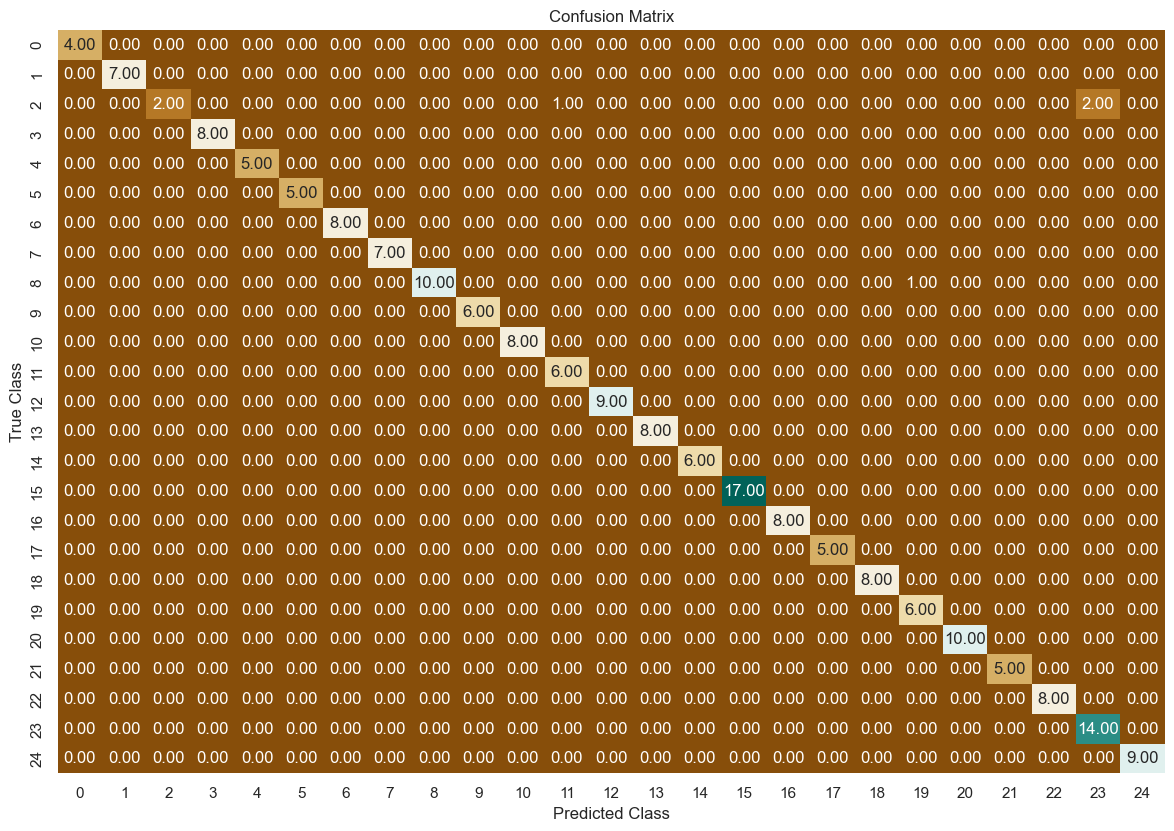

In [890]:
acc = accuracy_score(y_test, prediction)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(y_test, prediction)

In [767]:
pred = LabelEncoder.inverse_transform(prediction)
pred

array(['Java Developer'], dtype=object)

In [859]:
import xgboost
xgboost_classifier = xgboost.XGBClassifier()

In [860]:
xgboost_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [861]:
print('Accuracy of XGBoost Classifier on training set: {:.2f}'.format(xgboost_classifier.score(X_train, y_train)))
print('Accuracy of XGBoost Classifier on test set:     {:.2f}'.format(xgboost_classifier.score(X_test, y_test)))

Accuracy of XGBoost Classifier on training set: 0.95
Accuracy of XGBoost Classifier on test set:     0.96


In [863]:
y_pred = xgboost_classifier.predict(X_test)

Accuracy is 95.855 %


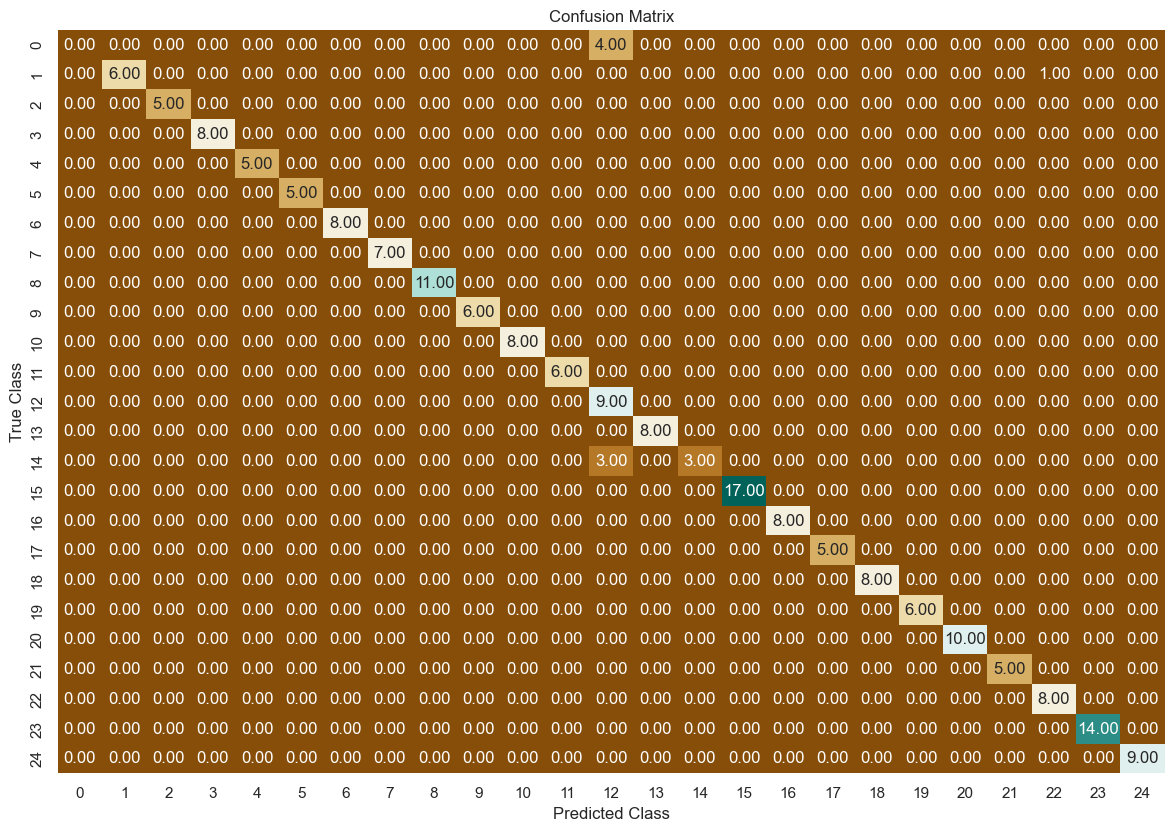

In [891]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(y_test, y_pred)

#### Count Vectorizer:

In [ ]:
def split_data(inputText, Labeled_Data):
    X_train, X_test, y_train, y_test = train_test_split(inputText,
                                                        Labeled_Data,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=324,
                                                        stratify=Labeled_Data)

                                                                          
    return X_train, X_test, y_train, y_test

In [ ]:
split_data(inputText, Labeled_Data)

In [880]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

inputText_features = 'Resume_Cleaned'
Labeled_Data_target = 'Category'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, inputText_features)
])

print('Datasets shapes before processing: ', train.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
print('Datasets shapes after processing: ', f'train_matrix: {train_matrix.shape}', f'test_matrix: {test_matrix.shape}')

Datasets shapes before processing:  (769, 3) (193, 3)
Datasets shapes after processing:  train_matrix: (769, 500) test_matrix: (193, 500)
Wall time: 210 ms


In [881]:
CV_X_train , CV_y_train = train_matrix ,train['Category']
CV_X_test , CV_y_test =   test_matrix , test['Category']
print(CV_X_train.shape , CV_y_train.shape , CV_X_test.shape , CV_y_test.shape)

(769, 500) (769,) (193, 500) (193,)


In [882]:
OneVsRestClassifier2 = OneVsRestClassifier(KNeighborsClassifier())

In [883]:
OneVsRestClassifier2.fit(CV_X_train, CV_y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [884]:
print('Accuracy of KNeighbors Classifier2 on training set: {:.2f}'.format(OneVsRestClassifier2.score(CV_X_train, CV_y_train)))
print('Accuracy of KNeighbors Classifier2 on test set:     {:.2f}'.format(OneVsRestClassifier2.score(CV_X_test, CV_y_test)))

Accuracy of KNeighbors Classifier2 on training set: 0.97
Accuracy of KNeighbors Classifier2 on test set:     0.95


In [870]:
sample = ['system administrator engineer system administrator engineer wellsfargo tom river nj linux unix system administrator engineer talented passionate system engineer 6 year plus experience system engineer strong analytical troubleshooting ability deep understanding linux red hat networking virtualization management cloud computing aws devops automation puppet ansible excellent interpersonal skill experience working team productively troubleshoot resolve challenging technical issue career profile expertise rhel 567 racking stacking server provisioning experience setting different raid level experience building hypervisors installing vmware esxi bare metal machine experience provisioning server using pxeboot kickstart automate installation o expertise configuring managing troubleshooting different server nfs ni autofs yum repository server dns dhcp ftp samba ldap lamp experience disk partitioning using fdisk creation management physical volume volume group logical volume using lvm creating various file system logical volume well resizing includes extending shrinking using lvm experience configuring monitoring troubleshooting different file system ext 2 3 4 xfs well upgrading file system needed using tune f experience installation configuration backup recovery maintenance support red hat linux flavor applying patch security fix using ansible blade logic redhat satellite server experience yum rpm install various package redhat linux environment well actively applying security patch keep production development configuration nic bonding redundancy performance round robin active backup increase network bandwidth redundancy nic card experience creating managing virtual machine cluster migration vms host host using vmotion vcenter wrote script day day task groupuser administration start shutdown script crontabs experience configuring ansible server automation writing adhoc command playbook user management creating server deployment system build configuration using ansible puppet well monitoring setting sensor using nagios experience using various network protocol like ssh scp sftp http tcpip udp ftp smtp experience kernel tuning needed especially virtual memory swap space excellent verbal written communication skill experience direct internal external client relationship management ability learn adapt new different technology working depth quickly efficiently 247 customer support service delivery experience authorized work united state employer work experience system administrator engineer wellsfargo tom river nj january 2016 present knowledge aws administration includes deploying configuring ec2 instance s3 managing iam role installing maintaining administration troubleshooting linux unix system working directly vendor decommission thousand server networking equipment following company rule regulation working vendor replace server part ordering new hardware keeping track system inventory commissioning decommissioning hp asset deleting data server ensuring data destruction decommissioning asset securing ssh key based authentication rsa encryption setting autofs mounting home directory ni ldap configuration providing direct user support level 2 level 3 issue via email ticket system providing timely responsive assistance company employee troubleshooting problem reported helpdesk ticketing system experienced using network traffic monitoring tool wireshark tcpdump performing automated installation operating system network various distribution redhat centos ubuntu fedora well server provisioning tool hpsa working different storage container creating raid level 0 1 5 6 10 achieve redundancy performance compile opensource software source code generate necessary rpm package proper documentation replication across server environment performing daily system monitoring verifying integrity availability hardware server resource system key process reviewing system application log verifying completion scheduled job backup performing filesystem check repairing needed repairing rebuilding existing server per project requirement responsible backing system using netbackup 75 restoring file event data loss setup cron job schedule various backup monitoring task supported enterprise backup using netbackup monitoring netbackup queue failed backup job taking action fix responsible user management includes creating modifying renewing user account group linux ni ldap well active directory setting ni domain master server slave client resolving authentication issue mounting user home directory automount setting quota system installation esxi hypervisor server vsphere client vcenter server installing esxi server 55 60 building vcenter adding esxi server creating moving cloning vms using vcenter vsphere well vmotion automating aspect vmware vsphere infrastructure vmware vrealize orchestrator testing deploying security patch number system dev production environment perform software package installation upgrade update using yum rpm command maintaining inventory incoming outgoing equipment monitoring ups system generated alert monitoring infrastructure health using nagios proprietary data center monitoring tool working different file system ext3 ext4 xfs nfs partitioning using fdisk parted create different partition creating fixing file system maintaining yum repository server patch management well securing linux system using local repository installing upgrading application linux system helping user management creating modifying disabling account set home directory server added user appropriate group assigned sudo access requested created managed logical volume using lvm create volume volume group file system performing physical virtual machine conversion performing critical system administration task single user mode creating mount point database administrator supported mysql database configure ntp client server synchronize time zone ntp server responding alert generated nagios network connectivity issue critical system service application availability high cpu spike system resource maxed research evaluates recommends software hardware product actively participated data center operation building scaling server ordering hardware racking ability pick heavy equipment solid understanding working knowledge storage technology san na iscsi troubleshooting linux network security related issue capturing packet using tool iptables firewall tcp wrapper nmap troubleshooting maintaining tcpip apache http smtp dns application installing managing new server includes racking stacking cabling running fiber lan patch configured multiple website one apache http server using virtualhost container creatingupdating iptables rule linux system using hostbased firewall solving issue related user logon nfs server connectivity configuring nfs server mount exported nfs resource client side experience bash scripting creating modifying bash script automate daily task setup nfs samba file sharing setup linux window server machine conducting system performance tuning capacity planning solving challenging issue solid problemsolving approach monitored system log activity server resolved system process issue reported site scope worked hp integrated light ilo dell idrac ibm imm oracle ilom software remotely manage troubleshoot repair server developing maintaining installation configuration procedure researching recommending innovative possible automating approach system administration task configuring network adapter ip address resolving routing related issue experience configuring troubleshooting tcpip dhcp dns ftp ssh ldap ntp etc configuring managing vsftp server ticket assessmentprioritization daily basis rt platform daily system monitoring using nagios xi solarwinds monitoring resolving reported issue installed configure openstack linux system administrator kpmg montville nj february 2013 november 2015 installing managing new server includes racking stacking cabling running fiber lan patch responsible installation esxi bare metal server experience troubleshooting providing problem resolution software issue performed systemmonitoring tool like top sar vmstat iostat report system usage performance performing automated installation deployed rpm package using automation tool server automation pxeboot customized kick start file strongly experienced installing performing maintaining raid technology different raid level attempt recover data disk performed system security administration user administration using role based access control provided sudo access various user group elevated access create user group account network configuration manage password permission performed daily system monitoring verifying integrity availability hardware server resource system process viewing system application log verify completion scheduled job attached na da storage linux esxi server creating standard partition creating physical volume group volume logical volume extendingreducing logical volume server startup shutdown issue well service linux server managing file system utilization using script scheduling cron job maintain file system host security using chmod chown chgrp iptables configured network adapter ip address resolving routing related issue hand experience troubleshooting network memory cpu swap file system issue tcpip smtp linux server performed software package installation upgrade update using yum rpm command tested deployed security patch number system development production environment performing critical system administration task single user mode configured nfs server mounted exported nfs resource client side experience supporting 247 production computing environment experience providing oncall weekend support performed setting secured password le ssh authentication server using ssh key pair monitored system log activity server configure ntp client server synchronize time zone ntp server participated weekly meeting documentation environment linux system administrator comcast philadelphia pa march 2012 december 2013 managed maintained file directory group user account performed o installation configuration testing implementing server environment created simple linux script incorporating bash python server maintenance backup leveraged spiceworks deploy ticketing help desk client use window environment leveraged o ticket deploy support ticket system client use linux environment configured gmail account act smtp server order send email client administrator ticket update responded level 1 ticket escalated ticket necessary installed configured various linux service including ftp http postgresql mariadb php dns dhcp utilized remote desktop manager ssh access test production environment remotely monitored application process linux server troubleshooted application slowness education master skill dns 6 year ldap 5 year']
count_vec = CountVectorizer(max_features=500)
sample_count_vec = count_vec.fit_transform(sample)
sample_count_vec.shape

(1, 500)

In [871]:
predictionsample = OneVsRestClassifier2.predict(sample_count_vec)
predictionsample

array([8])

In [872]:
predict = LabelEncoder.inverse_transform(predictionsample)
predict

array(['DevOps Engineer'], dtype=object)

In [875]:
XGBoost_Classifier2 = xgboost_classifier.fit(CV_X_train,CV_y_train)

In [876]:
print('Accuracy of XGBoost Classifier on training set: {:.2f}'.format(XGBoost_Classifier2.score(CV_X_train, CV_y_train)))
print('Accuracy of XGBoost Classifier on test set:     {:.2f}'.format(XGBoost_Classifier2.score(CV_X_test, CV_y_test)))

Accuracy of XGBoost Classifier on training set: 1.00
Accuracy of XGBoost Classifier on test set:     1.00


In [877]:
XGB_y_pred = XGBoost_Classifier2.predict(CV_X_test)

Accuracy is 100.000 %


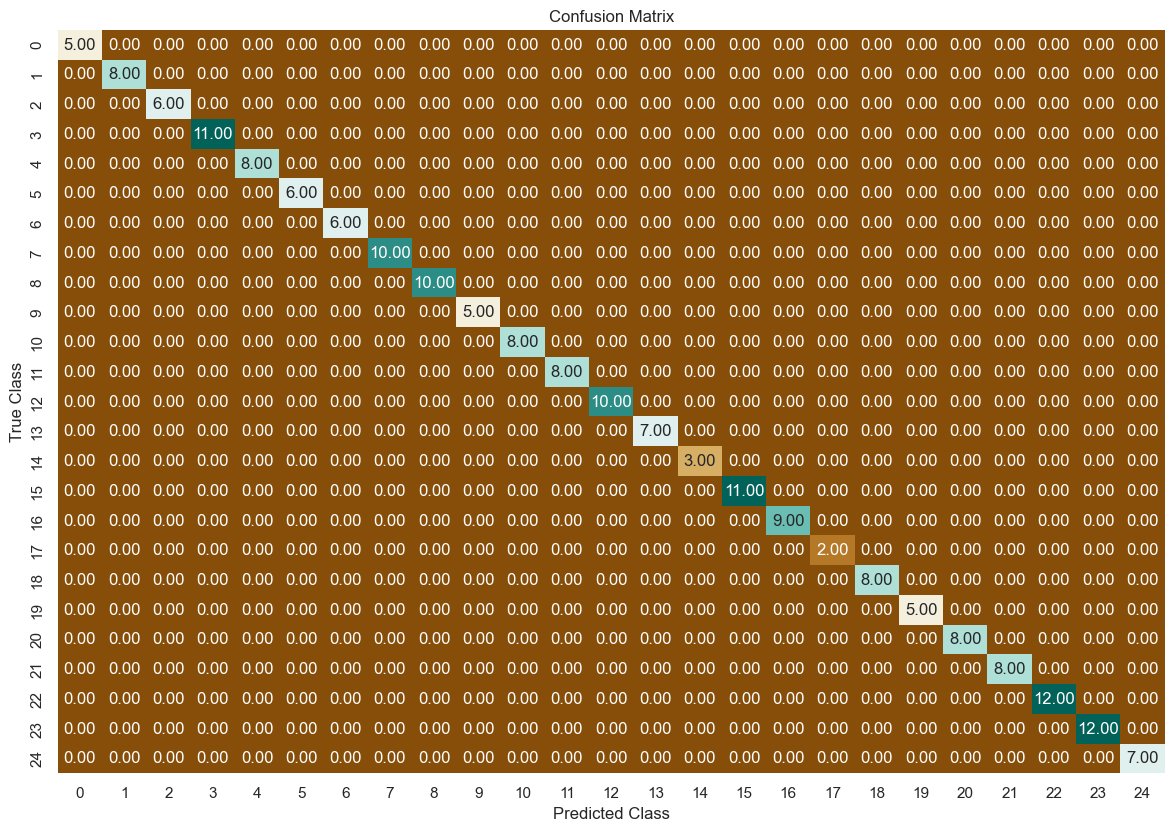

In [892]:
acc = accuracy_score(CV_y_test, XGB_y_pred)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(CV_y_test, XGB_y_pred)

# Job Classifications as per resume Skills:

In [837]:
myData2 = data_1.copy()
categories = myData2['Category'].value_counts().reset_index()
categories

,index,Category
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


In [838]:
import re
def clean_function(resumeText):
    resumeText = re.sub('http\S+\s', ' ', resumeText)  # remove URLs
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText.lower())  # remove extra whitespace
    return resumeText

In [839]:
myData2['skills'] = [' '.join(map(str, l)) for l in myData2['skills']]
myData2

,Category,Resume,Resume_Cleaned,skills
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda numpy ...,angular mysql computer vision elasticsearch an...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may 2013 may 2017 b e uit rgp...,machine learning outlier business feature sele...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...,mysql segmentation analytics github segment so...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,data processing segmentation analytics segment...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...,data analysis python data structure database d...
...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,computer skill proficient m office word basic ...,electrical engineering diagram relay testing
958,Testing,â Willingness to accept the challenges. â ...,willingness accept challenge positive thinking...,engineering documentation debugging system tes...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skill quick learner eagerness learn n...,functional testing support engineering documen...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skill software knowledge m power poin...,software latex design


In [840]:
myData2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        962 non-null    object
 1   Resume          962 non-null    object
 2   Resume_Cleaned  962 non-null    object
 3   skills          962 non-null    object
dtypes: object(4)
memory usage: 30.2+ KB


In [841]:
myData2.isnull().sum()

Category          0
Resume            0
Resume_Cleaned    0
skills            0
dtype: int64

In [842]:
myData2['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [843]:
myData2.drop(columns=['Resume'] , inplace = True)

In [844]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder = preprocessing.LabelEncoder()
myData2['Category'] = LabelEncoder.fit_transform(myData2['Category'])

In [845]:
myData2.head()

,Category,Resume_Cleaned,skills
0,6,skill programming language python panda numpy ...,angular mysql computer vision elasticsearch an...
1,6,education detail may 2013 may 2017 b e uit rgp...,machine learning outlier business feature sele...
2,6,area interest deep learning control system des...,mysql segmentation analytics github segment so...
3,6,skill r python sap hana tableau sap hana sql s...,data processing segmentation analytics segment...
4,6,education detail mca ymcaust faridabad haryana...,data analysis python data structure database d...


## Splitting the data to Train & Test:

In [849]:
myData2['skills'][900]

'selenium linux database time constraint software testing'

In [850]:
text2= myData2['skills'].values
Target2 = myData2['Category'].values

#### TF IDF Vectorizer:

In [955]:
word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
word_vectorizer.fit(text2)
vectorizedData2 = word_vectorizer.transform(text)

print ("Feature completed .....")

Feature completed .....


In [956]:
def split_data(inputText, Labeled_Data):
    X_train, X_test, y_train, y_test = train_test_split(inputText,
                                                        Labeled_Data,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=324,
                                                        stratify=Labeled_Data)

                                                                          
    return X_train, X_test, y_train, y_test

In [957]:
X_train, X_test, y_train, y_test = split_data(vectorizedData2, Target2)
print(f'X_train {X_train.shape}')
print(f'X_test  {X_test.shape}')
print(f'y_train {y_train.shape}')
print(f'y_test  {y_test.shape}')

X_train (769, 297)
X_test  (193, 297)
y_train (769,)
y_test  (193,)


In [958]:
OneVsRestClassifier1 = OneVsRestClassifier(KNeighborsClassifier())

In [959]:
OneVsRestClassifier1.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [960]:
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(OneVsRestClassifier1.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(OneVsRestClassifier1.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.93
Accuracy of KNeighbors Classifier on test set:     0.90


In [961]:
prediction = OneVsRestClassifier1.predict(X_test)

Accuracy is 90.155 %


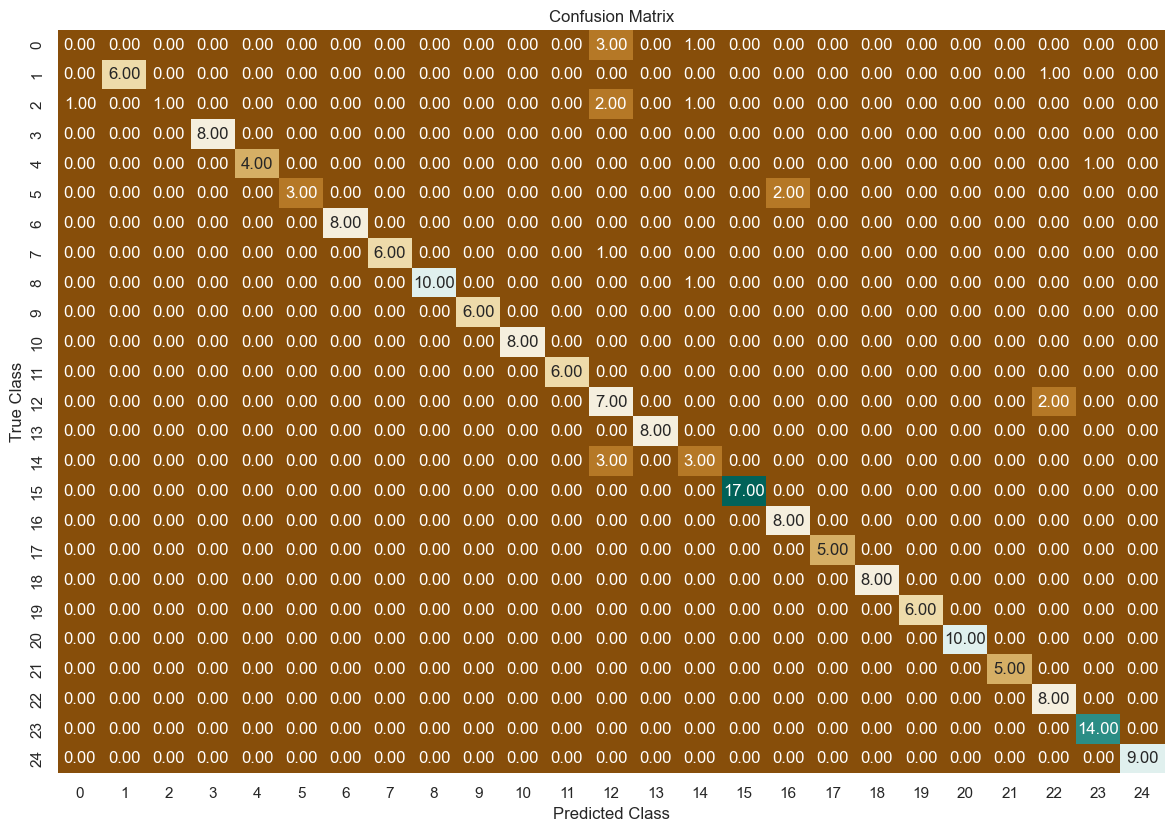

In [962]:
acc = accuracy_score(y_test, prediction)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(y_test, prediction)

#### Count Vectorizer:

In [902]:
text2= myData2['skills'].values
Target2 = myData2['Category'].values
myData2

,Category,Resume_Cleaned,skills
0,6,skill programming language python panda numpy ...,angular mysql computer vision elasticsearch an...
1,6,education detail may 2013 may 2017 b e uit rgp...,machine learning outlier business feature sele...
2,6,area interest deep learning control system des...,mysql segmentation analytics github segment so...
3,6,skill r python sap hana tableau sap hana sql s...,data processing segmentation analytics segment...
4,6,education detail mca ymcaust faridabad haryana...,data analysis python data structure database d...
...,...,...,...
957,23,computer skill proficient m office word basic ...,electrical engineering diagram relay testing
958,23,willingness accept challenge positive thinking...,engineering documentation debugging system tes...
959,23,personal skill quick learner eagerness learn n...,functional testing support engineering documen...
960,23,computer skill software knowledge m power poin...,software latex design


In [928]:
myData2['skills'][2]

'mysql segmentation analytics github segment software pycharm data analysis deep learning data science flask business engineering django machine learning design java electrical engineering ubuntu python jupyter notebook eclipse marketing operating system'

In [900]:
def split_data2(inputText):
    train, test = train_test_split(inputText,
                                                        
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=324,
                                                        #stratify=Labeled_Data
                                                       )

                                                                          
    return train, test

In [903]:
train, test = split_data2(myData2)
print(f'trainset {train.shape}')
print(f'testset  {test.shape}')

trainset (769, 3)
testset  (193, 3)


In [972]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

inputText_features = 'skills'
Labeled_Data_target = 'Category'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=28))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, inputText_features)
])

print('Datasets shapes before processing: ', train.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
print('Datasets shapes after processing: ', f'train_matrix: {train_matrix.shape}', f'test_matrix: {test_matrix.shape}')

Datasets shapes before processing:  (769, 3) (193, 3)
Datasets shapes after processing:  train_matrix: (769, 28) test_matrix: (193, 28)
Wall time: 13.9 ms


In [973]:
CV_X_train , CV_y_train = train_matrix ,train['Category']
CV_X_test , CV_y_test =   test_matrix , test['Category']
print(CV_X_train.shape , CV_y_train.shape , CV_X_test.shape , CV_y_test.shape)

(769, 28) (769,) (193, 28) (193,)


One Vs Rest Classifier(KNeighbors Algorithm):

In [974]:
OneVsRestClassifier2 = OneVsRestClassifier(KNeighborsClassifier())

In [975]:
OneVsRestClassifier2.fit(CV_X_train, CV_y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [976]:
print('Accuracy of KNeighbors Classifier2 on training set: {:.2f}'.format(OneVsRestClassifier2.score(CV_X_train, CV_y_train)))
print('Accuracy of KNeighbors Classifier2 on test set:     {:.2f}'.format(OneVsRestClassifier2.score(CV_X_test, CV_y_test)))

Accuracy of KNeighbors Classifier2 on training set: 0.88
Accuracy of KNeighbors Classifier2 on test set:     0.79


In [977]:
prediction = OneVsRestClassifier2.predict(CV_X_test)

Metices of OneVsRestClassifier (KNeighbors)

Accuracy is 79.275 %


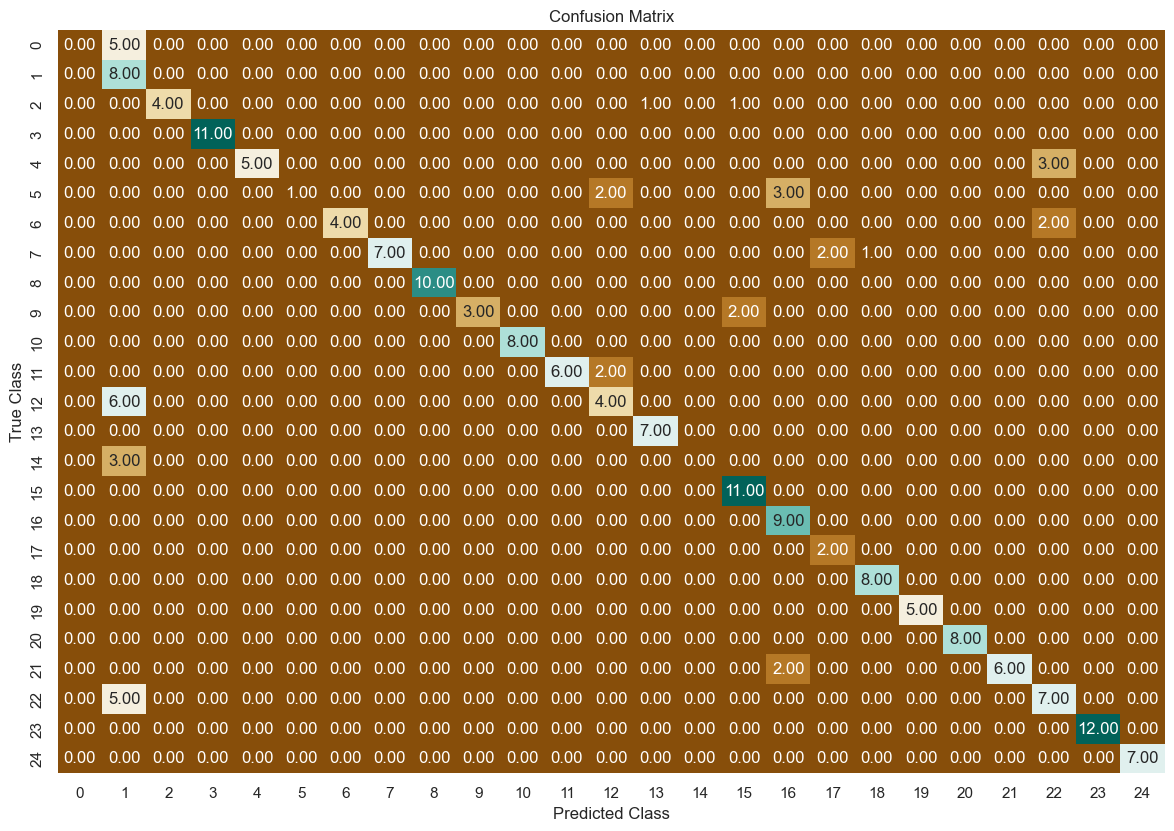

In [978]:
#Metices of OneVsRestClassifier (KNeighbors)
acc = accuracy_score(CV_y_test, prediction)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(CV_y_test, prediction)

In [979]:
sample = ['mysql segmentation analytics github segment software pycharm data analysis deep learning data science flask business engineering django machine learning design java electrical engineering ubuntu python jupyter notebook eclipse marketing operating system']
count_vec = CountVectorizer(max_features=300)
sample_count_vec = count_vec.fit_transform(sample)
sample_count_vec.shape

(1, 28)

In [980]:
predictionsample = OneVsRestClassifier2.predict(sample_count_vec)
predictionsample

array([9])

In [981]:
pred = LabelEncoder.inverse_transform(predictionsample)
pred

array(['DotNet Developer'], dtype=object)

XGBoost Algorithm:

In [982]:
import xgboost
XGBoost_Classifier2 = xgboost.XGBClassifier()

In [984]:
XGBoost_Classifier2 = xgboost_classifier.fit(CV_X_train,CV_y_train)


In [985]:
print('Accuracy of XGBoost Classifier on training set: {:.2f}'.format(XGBoost_Classifier2.score(CV_X_train, CV_y_train)))
print('Accuracy of XGBoost Classifier on test set:     {:.2f}'.format(XGBoost_Classifier2.score(CV_X_test, CV_y_test)))

Accuracy of XGBoost Classifier on training set: 0.91
Accuracy of XGBoost Classifier on test set:     0.85


In [986]:
y_pred = XGBoost_Classifier2.predict(CV_X_test)

Accuracy is 84.974 %


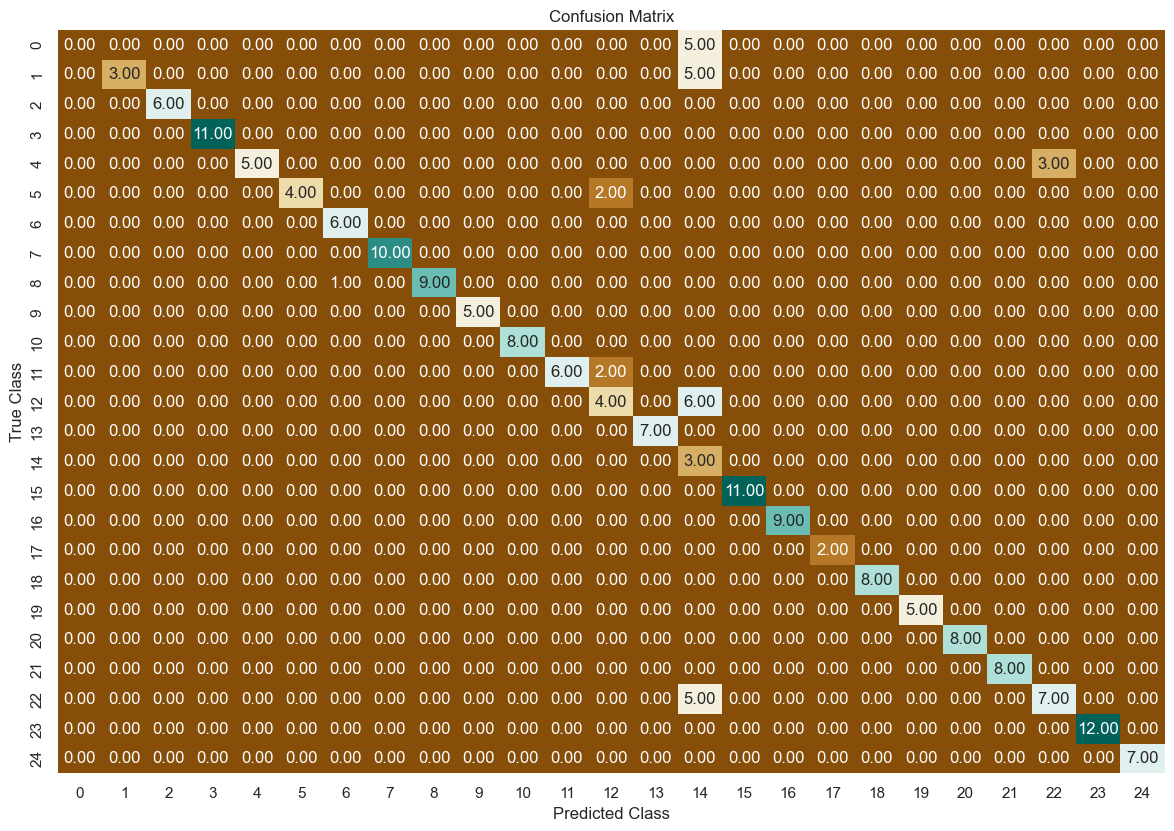

In [987]:
acc = accuracy_score(CV_y_test, y_pred)
print(f'Accuracy is {acc*100 :0.3f} %')
plot_confusion_matrix(CV_y_test, y_pred)

### Save & Load the trained Model:

In [994]:
import joblib
joblib.dump(OneVsRestClassifier1 , r'C:\Users\trainee\Jupyter NoteBooks\OneVsRestClassifier Model')
joblib.dump(XGBoost_Classifier2 , r'C:\Users\trainee\Jupyter NoteBooks\XGBoost_Classifier Model')

['C:\\Users\\trainee\\Jupyter NoteBooks\\XGBoost_Classifier Model']

In [996]:
loaded_Model = joblib.load(r'C:\Users\trainee\Jupyter NoteBooks\XGBoost_Classifier Model')
loaded_Model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Predict for test sample:

In [997]:
loaded_Model.predict(CV_X_test[0])

array([16], dtype=int64)